In [1]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import joblib

#import gensim

from nltk.corpus import stopwords, wordnet

from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, TweetTokenizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction import text
sk_learn_stopwords = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
nltk__stopwords = stopwords.words('english')
stop_words = sk_learn_stopwords.intersection(nltk__stopwords)

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve


def measure_performance(X,
                        y,
                        clf,
                        show_accuracy=True,
                        show_classification_report=True,
                        show_confusion_matrix=True,
                        show_r2_score=False):
    y_pred = clf.predict(X)
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)))
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y, y_pred), )
    if show_r2_score:
        print("Coefficient of determination:{0:.3f}".format(
            metrics.r2_score(y, y_pred)))
    return y_pred


from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve


def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes,
                     validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std,
                     alpha=0.1,
                     color="g")

    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(train_sizes,
             validation_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")
    plt.ylim(max(-3,
                 validation_scores_mean.min() - .1),
             train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()


from sklearn.model_selection import validation_curve


def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values,
                     validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std,
                     alpha=0.1,
                     color="g")
    plt.plot(parameter_values,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    plt.plot(parameter_values,
             validation_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()


def plot_roc(X_val, y_val, model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve")
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero],
             tpr[close_zero],
             'o',
             markersize=10,
             label="threshold zero",
             fillstyle="none",
             c='k',
             mew=2)
    plt.legend(loc=4)
    plt.show()


def test_classifier(model, X, y, cv):
    clf = model.fit(X, y.values.ravel())
    result = clf.score(X, y.values)
    print("Accuracy: {0:.3f}".format(result * 100.0))

    train_sizes, train_scores, validation_scores = learning_curve(
        clf, X, y.values.ravel(), cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf, result

In [4]:
CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

In [5]:
class CleanText(BaseEstimator, TransformerMixin):
    other_stopwords = [
        'pic.twitter.com', 'android', 'apple', 'appl', 'samsung', 'sony',
        'galaxy', 'ipad', 'iphone', 'iphon', 'iphones', 'iphonex', 'ipod',
        'itune', 'itun', 'itunes'
        'phone', 'phon', 'twit', 'twitter'
    ]

    def __init__(self, stop_words, stemmer):
        self.stop_words = stop_words
        self.stemmer = stemmer
        self.tokenizer = TweetTokenizer()

    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)

    def remove_accented_chars(self, input_text):
        text = unicodedata.normalize('NFKD', input_text).encode(
            'ascii', 'ignore').decode('utf-8', 'ignore')
        return text

    def remove_urls(self, input_text):
        input_text = re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
        input_text = re.sub(r'^RT[\s]+', '', input_text)
        for other_stopword in self.other_stopwords:
            if other_stopword == 'pic.twitter.com':
                other_stopword = other_stopword + '(.*)'
            input_text = re.sub(other_stopword, '', input_text)
        return input_text

    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_', '')

    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(
            punct,
            len(punct) *
            ' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)

    def to_lower(self, input_text):
        return input_text.lower()

    def remove_stopwords(self, input_text):

        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = self.tokenizer.tokenize(input_text)
        clean_words = [
            word for word in words
            if (word not in self.stop_words or word in whitelist)
        ]
        clean_words = [CONTRACTION_MAP.get(word, word) for word in clean_words]
        return " ".join(clean_words)

    def remove_repeated_characters(self, input_text):

        repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
        match_substitution = r'\1\2\3'
        tokens = input_text.split()

        def replace(old_word):
            if wordnet.synsets(old_word):
                return old_word
            new_word = repeat_pattern.sub(match_substitution, old_word)
            return replace(new_word) if new_word != old_word else new_word

        correct_tokens = [replace(word) for word in tokens]

        return " ".join(correct_tokens)

    def remove_shortwords(self, input_text):
        words = self.tokenizer.tokenize(input_text)
        words = [word for word in words if 2 < len(word) < 20]
        return " ".join(words)

    def stemming(self, input_text):
        words = self.tokenizer.tokenize(input_text)
        if isinstance(self.stemmer, WordNetLemmatizer):
            stemmed_words = [self.stemmer.lemmatize(word) for word in words]
        else:
            stemmed_words = [self.stemmer.stem(word) for word in words]
        return " ".join(stemmed_words)

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_accented_chars)
        clean_X = clean_X.apply(self.remove_mentions)
        clean_X = clean_X.apply(self.remove_urls)
        clean_X = clean_X.apply(self.emoji_oneword)
        clean_X = clean_X.apply(self.remove_stopwords)
        clean_X = clean_X.apply(self.remove_punctuation)
        clean_X = clean_X.apply(self.remove_digits)
        clean_X = clean_X.apply(self.remove_repeated_characters)
        clean_X = clean_X.apply(self.to_lower)

        clean_X = clean_X.apply(self.remove_shortwords)

        clean_X = clean_X.apply(self.stemming)
        clean_X = clean_X.apply(self.remove_shortwords)
        return clean_X

In [6]:
class TextCounts(BaseEstimator, TransformerMixin):
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))

    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self

    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x))
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x))
        count_capital_words = X.apply(
            lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))
        count_excl_quest_marks = X.apply(
            lambda x: self.count_regex(r'!|\?', x))
        count_urls = X.apply(
            lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x))
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(
            lambda x: self.count_regex(r':[a-z_&]+:', x))
        count_char = X.apply(lambda x: len(x))
        df = pd.DataFrame({
            'count_words': count_words,
            'count_mentions': count_mentions,
            'count_hashtags': count_hashtags,
            'count_capital_words': count_capital_words,
            'count_excl_quest_marks': count_excl_quest_marks,
            'count_urls': count_urls,
            'count_emojis': count_emojis,
            'count_char': count_char
        })

        return df

In [7]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [8]:
def grid_vect(clf,
              parameters_clf,
              X_train,
              y_train,
              X_test,
              y_test,
              parameters_text=None,
              vect=None,
              is_w2v=False):
    # 'count_capital_words'
    textcountscols = [
        'count_emojis',
        'count_excl_quest_marks',
        'count_hashtags',
        'count_mentions',
        'count_urls',
        'count_words',
    ]

    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion(
            [('textcounts', ColumnExtractor(cols=textcountscols)),
             ('w2v', ColumnExtractor(cols=w2vcols))],
            n_jobs=-1)
    else:
        features = FeatureUnion(
            [('textcounts', ColumnExtractor(cols=textcountscols)),
             ('pipe',
              Pipeline([('cleantext', ColumnExtractor(cols='clean_tweet')),
                        ('vect', vect)]))],
            n_jobs=-1)

    pipeline = Pipeline([('features', features), ('clf', clf)])

    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)

    if parameters_clf:
        parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               n_jobs=-1,
                               verbose=1,
                               cv=5)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    print("Test score with best_estimator_: %0.3f" %
          grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(
        classification_report(y_test,
                              grid_search.best_estimator_.predict(X_test)))

    return grid_search

In [9]:
train_df = pd.read_csv('train.csv')

In [10]:
test_df = pd.read_csv('test.csv')

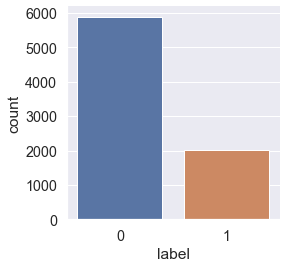

In [11]:
target_dist = sns.factorplot(x="label", data=train_df, kind="count", size=4)

In [12]:
tc = TextCounts()
df_eda = tc.fit_transform(train_df['tweet'])
df_eda['label'] = train_df['label']

In [13]:
df_eda_test = tc.fit_transform(test_df['tweet'])

In [14]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-' * (len(col) + 22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='label', size=4, hue='label', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
        count       mean       std  min   25%   50%   75%   max
label                                                          
0      5894.0  20.091279  6.633338  1.0  16.0  18.0  21.0  60.0
1      2026.0  18.782330  5.346050  9.0  15.0  18.0  22.0  58.0


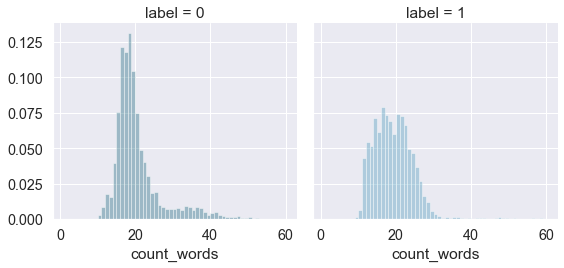

In [15]:
show_dist(df_eda, 'count_words')

In [16]:
df_eda[df_eda['count_words'].isin([60, 58])]

,count_words,count_mentions,count_hashtags,count_capital_words,count_excl_quest_marks,count_urls,count_emojis,count_char,label
1794,58,0,3,0,3,1,0,329,1
4494,60,0,15,2,0,1,0,391,0
4740,60,0,14,0,1,1,0,348,0


In [17]:
train_df.loc[df_eda[df_eda['count_words'].isin([1, 9, 60, 58])].index]

,id,label,tweet
1794,1795,1,¿Me lo dices o me lo preguntas #Apple ? Ya mi ...
1798,1799,1,End to End system. = $&@*# to $&@*# system! #A...
2156,2157,0,Got new iPhone !! :D Very Happy !! #Apple #iPh...
2611,2612,1,@Eric_Can7ona: @SK77_M14 haha I thought s was ...
4494,4495,0,GT08 Bluetooth Smartwatch Smart Watch with SIM...
4740,4741,0,http://amazon.com/dp/B004CYKEBK?tag=amausrecma...
5253,5254,0,im going to instal my #sony vegas 11 now .. ;>
6340,6341,0,#ERROR!
6758,6759,1,@Bethanpie she broke her mac book :) :) except...


Descriptive stats for count_mentions
------------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0      5894.0  0.156770  0.460034  0.0  0.0  0.0  0.0  6.0
1      2026.0  0.211254  0.520011  0.0  0.0  0.0  0.0  5.0


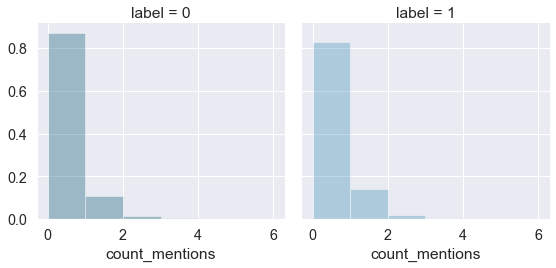

In [18]:
show_dist(df_eda, 'count_mentions')

Descriptive stats for count_hashtags
------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5894.0  7.337801  4.857942  0.0  4.0  7.0  9.0  33.0
1      2026.0  1.788746  2.095920  0.0  0.0  1.0  2.0  26.0


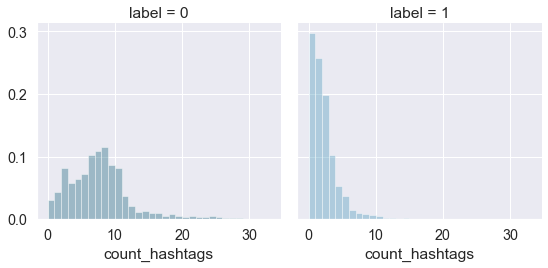

In [19]:
show_dist(df_eda, 'count_hashtags')

Descriptive stats for count_capital_words
-----------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5894.0  0.501188  1.480428  0.0  0.0  0.0  0.0  33.0
1      2026.0  0.524679  1.842337  0.0  0.0  0.0  0.0  25.0


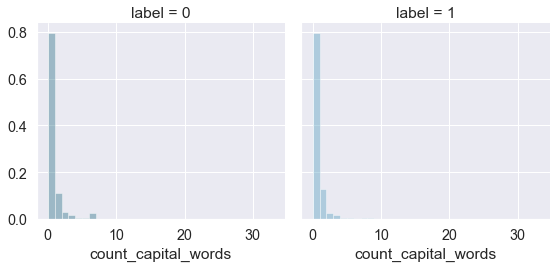

In [20]:
show_dist(df_eda, 'count_capital_words')

Descriptive stats for count_excl_quest_marks
--------------------------------------------
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5894.0  0.545470  1.097435  0.0  0.0  0.0  1.0  21.0
1      2026.0  0.637216  1.278571  0.0  0.0  0.0  1.0  13.0


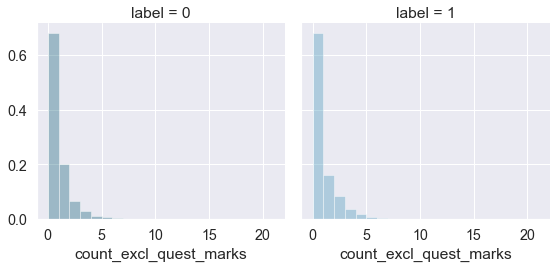

In [21]:
show_dist(df_eda, 'count_excl_quest_marks')

Descriptive stats for count_urls
--------------------------------
        count      mean       std  min  25%  50%  75%  max
label                                                     
0      5894.0  0.725484  0.498740  0.0  0.0  1.0  1.0  5.0
1      2026.0  0.101678  0.307161  0.0  0.0  0.0  0.0  3.0


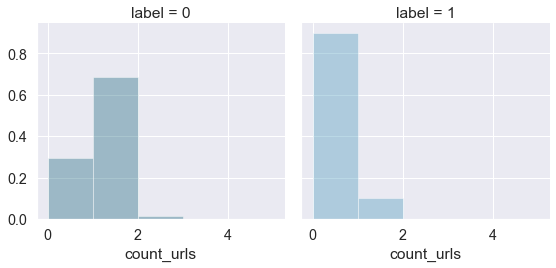

In [22]:
show_dist(df_eda, 'count_urls')

Descriptive stats for count_emojis
----------------------------------
        count     mean       std  min  25%  50%  75%  max
label                                                    
0      5894.0  0.00017  0.013026  0.0  0.0  0.0  0.0  1.0
1      2026.0  0.00000  0.000000  0.0  0.0  0.0  0.0  0.0


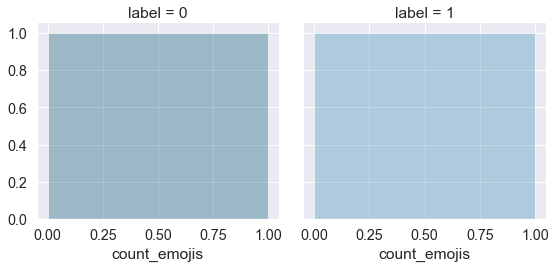

In [23]:
show_dist(df_eda, 'count_emojis')

In [24]:
stopwords = stopwords.words('english')
other_stopwords = [
    'android', 'apple', 'appl', 'samsung', 'sony', 'galaxy', 'ipad', 'iphone',
    'iphon', 'iphones', 'iphonex', 'ipod', 'itune', 'itun', 'itunes'
    'phone', 'phon', 'twit', 'twitter'
]
stopwords.extend(other_stopwords)

In [25]:
stemmer = PorterStemmer()
#ls = LancasterStemmer()
#stemmer = WordNetLemmatizer()
ct = CleanText(stopwords, stemmer)
train_df['clean_tweet'] = ct.fit_transform(train_df['tweet'])
test_df['clean_tweet'] = ct.transform(test_df['tweet'])

In [26]:
train_clean = train_df['tweet'] == ''
train_df.loc[train_clean] = '[no_text]'

In [27]:
test_clean = test_df['tweet'] == ''
test_df.loc[test_clean] = '[no_text]'

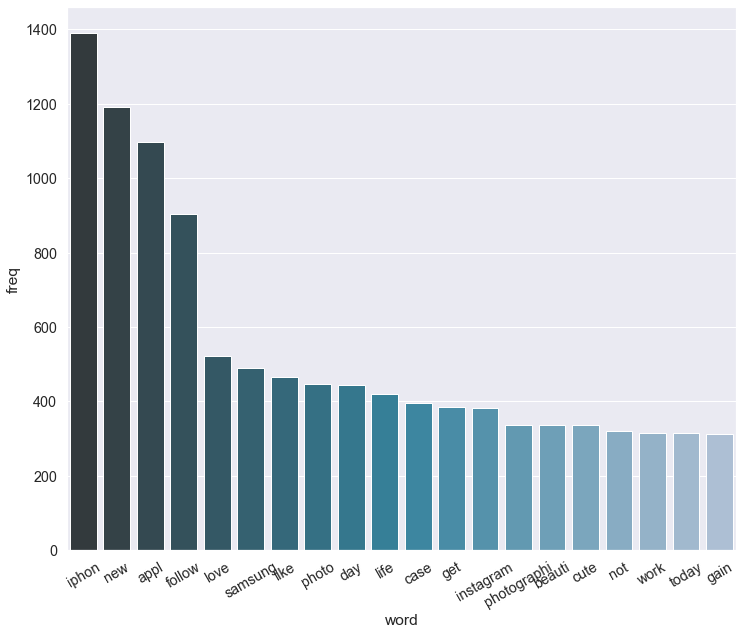

In [28]:
cv = CountVectorizer()
bow = cv.fit_transform(train_df['clean_tweet'])
word_freq = dict(
    zip(cv.get_feature_names(),
        np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20),
                               columns=['word', 'freq'])

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
bar_freq_word = sns.barplot(x="word",
                            y="freq",
                            data=word_counter_df,
                            palette="PuBuGn_d",
                            ax=ax)

In [29]:
train_data = df_eda
train_data['clean_tweet'] = train_df['clean_tweet']

In [30]:
train_data['clean_tweet'].head()

0    fingerprint pregnanc test beauti cute health i...
1    final transpar silicon case thank uncl yay son...
2    love would talk makememori unplug relax smart ...
3          wire know georg made way cute daventri home
4    what amaz servic appl even talk question unl p...
Name: clean_tweet, dtype: object

In [31]:
test_data = df_eda_test
test_data['clean_tweet'] = test_df['clean_tweet']

In [32]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

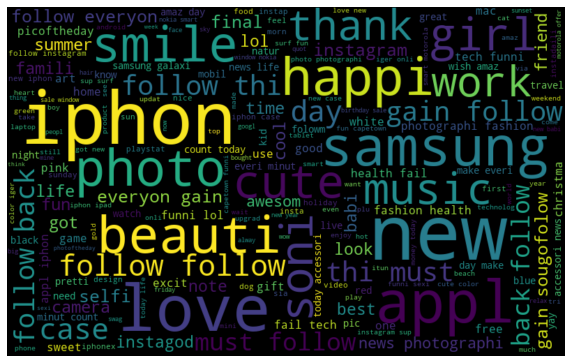

In [33]:
all_words_pos = ' '.join(
    [text for text in train_data[train_data['label'] == 0]['clean_tweet']])


def plot_wordcloud(all_words):
    wordcloud = WordCloud(width=800,
                          height=500,
                          random_state=21,
                          max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    return plt


word_plt = plot_wordcloud(all_words_pos)
word_plt.show()

In [34]:
all_words_neg = ' '.join(
    [text for text in train_data[train_data['label'] == 1]['clean_tweet']])

In [35]:
pw = pd.DataFrame(all_words_neg.split(), columns=['word'])
pw['word_len'] = pw['word'].apply(lambda x: len(x))
pw.to_csv('negative_words.csv', index=False)

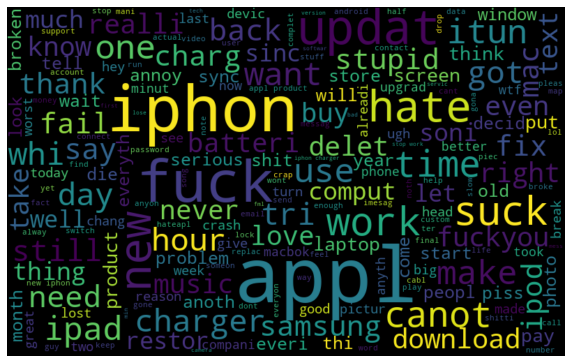

In [36]:
word_plt_neg = plot_wordcloud(all_words_neg)
word_plt_neg.show()

In [37]:
#ct.fit_transform(train_df['tweet'])
#train_df.info()
#ct.transform(train_df[train_df['id']==6]['tweet'])

In [38]:
def get_long_words(row):
    return [word for word in row.split() if len(word) > 8]

In [39]:
train_df['long_words'] = train_df['clean_tweet'].apply(get_long_words)

In [40]:
train_df.head()

,id,label,tweet,clean_tweet,long_words
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnanc test beauti cute health i...,[fingerprint]
1,2,0,Finally a transparant silicon case ^^ Thanks t...,final transpar silicon case thank uncl yay son...,[]
2,3,0,We love this! Would you go? #talk #makememorie...,love would talk makememori unplug relax smart ...,[makememori]
3,4,0,I'm wired I know I'm George I was made that wa...,wire know georg made way cute daventri home,[]
4,5,1,What amazing service! Apple won't even talk to...,what amaz servic appl even talk question unl p...,[]


In [41]:
freq = pd.Series(' '.join(
    train_df['clean_tweet']).split()).value_counts().to_frame().reset_index()

In [42]:
freq = freq.rename(columns={"index": "word", 0: "length"})
freq.head()

,word,length
0,iphon,1391
1,new,1191
2,appl,1097
3,follow,903
4,love,522


In [43]:
Check

NameError: name 'Check' is not defined

In [ ]:
train_df.to_csv('PreprocessedTrain.csv', index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
test_size = 0.15
seed = 42
kfold = StratifiedKFold(n_splits=5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data,
                                                    train_df['label'],
                                                    test_size=test_size,
                                                    random_state=seed)

In [ ]:
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (
        1,
        2,
    )
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {'clf__alpha': (0.1, 0.25, 0.5, 0.75)}

# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 0.75, 1.0),
    'clf__penalty': ('l1', 'l2')
}

parameters_sgd = {'clf__alpha': (0.0001, 0.001, 0.01, 0.006)}

In [ ]:
mnb = MultinomialNB()
logreg = LogisticRegression()
sgd = SGDClassifier(tol=1e-3, random_state=42)

In [ ]:
countvect = CountVectorizer()
tfidfvect = TfidfVectorizer()

In [ ]:
# best_sgd_countvect = grid_vect(sgd, parameters_sgd, X_train,y_train ,X_test,y_test ,
#                                parameters_text=parameters_vect, vect=countvect)

In [ ]:
# best_sgd_tfidfvect = grid_vect(sgd, parameters_sgd, X_train,y_train ,X_test,y_test ,
#                                parameters_text=parameters_vect, vect=tfidfvect)

In [ ]:
best_mnb_countvect = grid_vect(mnb,
                               parameters_mnb,
                               X_train,
                               y_train,
                               X_test,
                               y_test,
                               parameters_text=parameters_vect,
                               vect=countvect)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [ ]:
plot_roc(X_test, y_test, best_mnb_countvect)
y_val = best_mnb_countvect.predict(X_test)
print(metrics.classification_report(y_test, y_val))

In [ ]:
# best_lg_countvect = grid_vect(logreg, parameters_logreg, X_train,y_train ,X_test,y_test ,
#                                parameters_text=parameters_vect, vect=countvect)

# best_mnb_tfidfvect = grid_vect(mnb, parameters_mnb, X_train,y_train ,X_test,y_test ,
#                                parameters_text=parameters_vect, vect=tfidfvect)

# plot_roc(X_test,y_test,best_lg_countvect)
# y_val = best_lg_countvect.predict(X_test)
# print(metrics.classification_report(y_test,y_val))

# plot_roc(X_test,y_test,best_mnb_tfidfvect)
# y_val = best_mnb_tfidfvect.predict(X_test)
# print(metrics.classification_report(y_test,y_val))

# best_lg_tfidfvect = grid_vect(logreg, parameters_logreg, X_train,y_train ,X_test,y_test ,
#                                parameters_text=parameters_vect, vect=tfidfvect)

# plot_roc(X_test,y_test,best_lg_tfidfvect)
# y_val = best_lg_tfidfvect.predict(X_test)
# print(metrics.classification_report(y_test,y_val))

In [ ]:
check

In [ ]:
y_pred = best_mnb_countvect.predict(test_data)
#y_pred = sclf.predict(test_data)

In [ ]:
from datetime import datetime
filename = f"submission_Stacking_MNB_{datetime.now().strftime('%Y%m%d%H%M%S')}.csv"

In [ ]:
submission_df = test_df.copy()
submission_df.drop(['clean_tweet', 'tweet'], axis=1, inplace=True)
submission_df['label'] = y_pred
submission_df.to_csv(filename, index=False)